### Imports

In [1025]:
# import necessary python libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy.stats import pearsonr
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

### Load Data

In [1026]:
# Monthly volume lag time series data
df = pd.read_csv('P.Oakley Existing Customer Volume.csv', parse_dates=['Month'])
df = df.set_index('Month')
df

,1M Lag Volume,2M Lag Volume,3M Lag Volume,4M Lag Volume,5M Lag Volume,6M Lag Volume
Month,,,,,,
2016-06-01,0,0,0,0,0,0
2016-07-01,107000,0,0,0,0,0
2016-08-01,98000,68000,0,0,0,0
2016-09-01,37000,37000,21000,0,0,0
2016-10-01,61000,55000,54000,33000,0,0
...,...,...,...,...,...,...
2022-12-01,420454000,420165000,419482000,419153000,419139000,418871000
2023-01-01,498092000,464292000,463993000,463322000,463243000,463233000
2023-02-01,364078000,364062000,363457000,363103000,362466000,362428000


In [1027]:
# Existing marketing spend data
esm = pd.read_csv('Existing S&M Spend.csv', parse_dates=['Date']).drop(columns=['Unnamed: 3'])
esm = esm.set_index('Date')

In [1028]:
# Monthly correlation metrics
dm = pd.read_csv('Monthly Correlation Metrics.csv', parse_dates=['Month'])
dm = dm.set_index('Month')

In [1029]:
# Join volume and marketing spend data
data1 = pd.merge(df, esm, left_index=True, right_index=True, how='inner')
data1['Sales Team Farmer Expense'] = data1['Sales Team Farmer Expense']*1000
data1['Account Management'] = data1['Account Management']*1000

In [1030]:
# Joiin merged data frame with correlation metric data
cdata = pd.merge(data1, dm, left_index=True, right_index=True, how='inner').drop(columns=['EOMONTH'])

### Preview Data

In [1031]:
#cdata.drop(index=cdata.index[-1],axis=0,inplace=True)

In [1032]:
cdata

,1M Lag Volume,2M Lag Volume,3M Lag Volume,4M Lag Volume,5M Lag Volume,6M Lag Volume,Sales Team Farmer Expense,Account Management,Fed_Funds_Target_Rate,LIBOR___3_Month,United_States_Treasury_Constant_Maturity___1_Year,United_States_Treasury_Constant_Maturity___5_Year,United_States_Treasury_Constant_Maturity___10_Year,United_States_Treasury_Constant_Maturity___30_Year,US_Prime_Rate
2021-01-01,482539000,482533000,482533000,481996000,479035000,479032000,36260.0,28330.0,0.0025,0.002019,0.0010,0.0045,0.0111,0.0187,0.0325
2021-02-01,435043000,434894000,434881000,434881000,434680000,433006000,40650.0,28330.0,0.0025,0.001884,0.0008,0.0075,0.0144,0.0217,0.0325
2021-03-01,394415000,393084000,392976000,392953000,392953000,392500000,73410.0,28330.0,0.0025,0.001942,0.0007,0.0092,0.0174,0.0241,0.0325
2021-04-01,437883000,437757000,437594000,437437000,437422000,437422000,23810.0,28710.0,0.0025,0.001764,0.0005,0.0086,0.0165,0.0230,0.0325
2021-05-01,444177000,443989000,440914000,440725000,440391000,440374000,15740.0,36250.0,0.0025,0.001314,0.0005,0.0079,0.0158,0.0226,0.0325
2021-06-01,308709000,308692000,308591000,304642000,304459000,303962000,21220.0,28330.0,0.0025,0.001458,0.0007,0.0087,0.0145,0.0206,0.0325
2021-07-01,313384000,313099000,313086000,313023000,309455000,309348000,15780.0,28330.0,0.0025,0.001177,0.0007,0.0069,0.0124,0.0189,0.0325
2021-08-01,366614000,366335000,365865000,365856000,365715000,362468000,16550.0,40000.0,0.0025,0.001196,0.0007,0.0077,0.0130,0.0192,0.0325
2021-09-01,383026000,381948000,381487000,380867000,380828000,380563000,16110.0,41600.0,0.0025,0.001301,0.0009,0.0098,0.0152,0.0208,0.0325
2021-10-01,477088000,477035000,473375000,472892000,472169000,472126000,27820.0,68900.0,0.0025,0.001323,0.0015,0.0118,0.0155,0.0193,0.0325


### Initial linear regressions and correlations

##### Linear regression of Account Management on existing customer (lagged) volume

In [1033]:
results_df = pd.DataFrame()
input_df = cdata
for i in range(len(input_df.columns)-9):
    yVar = input_df[['1M Lag Volume', '2M Lag Volume', '3M Lag Volume', '4M Lag Volume', '5M Lag Volume', '6M Lag Volume']].iloc[:,i]
    xVar = input_df['Account Management']
    data = pd.merge(yVar, xVar, left_index=True, right_index=True, how="inner")
    X = data['Account Management']
    y = data.iloc[:,0]
    X = sm.add_constant(X)
    model=sm.OLS(y,X)
    results = model.fit()
    results_df = results_df.append({'Variable': data.columns[0], 'R-squared': results.rsquared, 'P-value': results.pvalues[1]}, ignore_index=True)
    # Calculate correlation between residual component and Fed Funds Target Rate
    correlation, p_value = pearsonr(data.iloc[:,0], data['Account Management'])
    print(f"Correlation between volume and account management spend: {correlation:.6f}")
    print(f"P-value: {p_value:.6f}")

Correlation between volume and account management spend: 0.064403
P-value: 0.744736
Correlation between volume and account management spend: 0.049118
P-value: 0.803973
Correlation between volume and account management spend: 0.050444
P-value: 0.798786
Correlation between volume and account management spend: 0.052963
P-value: 0.788959
Correlation between volume and account management spend: 0.054819
P-value: 0.781737
Correlation between volume and account management spend: 0.056304
P-value: 0.775970


C:\Users\cmasterson\AppData\Local\Temp\ipykernel_8972\2674870682.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Variable': data.columns[0], 'R-squared': results.rsquared, 'P-value': results.pvalues[1]}, ignore_index=True)
C:\Users\cmasterson\AppData\Local\Temp\ipykernel_8972\2674870682.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Variable': data.columns[0], 'R-squared': results.rsquared, 'P-value': results.pvalues[1]}, ignore_index=True)
C:\Users\cmasterson\AppData\Local\Temp\ipykernel_8972\2674870682.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Variable': data.columns[0], 'R-squared': results.rsquared, '

In [1034]:
output = results_df.sort_values(['R-squared', 'P-value'], ascending=False).reset_index().drop(columns='index')

In [1035]:
output

,Variable,R-squared,P-value
0,1M Lag Volume,0.004148,0.744736
1,6M Lag Volume,0.003170,0.775970
2,5M Lag Volume,0.003005,0.781737
3,4M Lag Volume,0.002805,0.788959
4,3M Lag Volume,0.002545,0.798786
5,2M Lag Volume,0.002413,0.803973


##### Linear regression of US_Prime_Rate on existing customer (lagged) volume

In [1036]:
results_df = pd.DataFrame()
input_df = cdata
for i in range(len(input_df.columns)-9):
    yVar = input_df[['1M Lag Volume', '2M Lag Volume', '3M Lag Volume', '4M Lag Volume', '5M Lag Volume', '6M Lag Volume']].iloc[:,i]
    xVar = input_df['US_Prime_Rate']
    data = pd.merge(yVar, xVar, left_index=True, right_index=True, how="inner")
    X = data['US_Prime_Rate']
    y = data.iloc[:,0]
    X = sm.add_constant(X)
    model=sm.OLS(y,X)
    results = model.fit()
    results_df = results_df.append({'Variable': data.columns[0], 'R-squared': results.rsquared, 'P-value': results.pvalues[1]}, ignore_index=True)
    correlation, p_value = pearsonr(data.iloc[:,0], data['US_Prime_Rate'])
    print(f"Correlation between volume and the US prime rate: {correlation:.6f}")
    print(f"P-value: {p_value:.6f}")

Correlation between volume and the US prime rate: -0.187070
P-value: 0.340487
Correlation between volume and the US prime rate: -0.210790
P-value: 0.281614
Correlation between volume and the US prime rate: -0.208807
P-value: 0.286272
Correlation between volume and the US prime rate: -0.206687
P-value: 0.291301
Correlation between volume and the US prime rate: -0.203646
P-value: 0.298617
Correlation between volume and the US prime rate: -0.200249
P-value: 0.306921


C:\Users\cmasterson\AppData\Local\Temp\ipykernel_8972\2211516335.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Variable': data.columns[0], 'R-squared': results.rsquared, 'P-value': results.pvalues[1]}, ignore_index=True)
C:\Users\cmasterson\AppData\Local\Temp\ipykernel_8972\2211516335.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Variable': data.columns[0], 'R-squared': results.rsquared, 'P-value': results.pvalues[1]}, ignore_index=True)
C:\Users\cmasterson\AppData\Local\Temp\ipykernel_8972\2211516335.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Variable': data.columns[0], 'R-squared': results.rsquared, '

In [1037]:
output = results_df.sort_values(['R-squared', 'P-value'], ascending=False).reset_index().drop(columns='index')

In [1038]:
output

,Variable,R-squared,P-value
0,2M Lag Volume,0.044433,0.281614
1,3M Lag Volume,0.043600,0.286272
2,4M Lag Volume,0.042720,0.291301
3,5M Lag Volume,0.041472,0.298617
4,6M Lag Volume,0.040100,0.306921
5,1M Lag Volume,0.034995,0.340487


##### Linear regression of account management and US Prime Rate on Existing customer volume lags

In [1039]:
results_df = pd.DataFrame()
input_df = cdata
for i in range(len(input_df.columns)-9):
    yVar = input_df[['1M Lag Volume', '2M Lag Volume', '3M Lag Volume', '4M Lag Volume', '5M Lag Volume', '6M Lag Volume']].iloc[:,i]
    xVar = input_df[['US_Prime_Rate', 'Account Management']]
    data = pd.merge(yVar, xVar, left_index=True, right_index=True, how="inner")
    X = data[['US_Prime_Rate', 'Account Management']]
    y = data.iloc[:,0]
    X = sm.add_constant(X)
    model=sm.OLS(y,X)
    results = model.fit()
    results_df = results_df.append({'Variable': data.columns[0], 'R-squared': results.rsquared, 'US P-Rate P-value': results.pvalues[1], 'Acc Mgmt P-value': results.pvalues[2]}, ignore_index=True)
    print(results.summary())

C:\Users\cmasterson\AppData\Local\Temp\ipykernel_8972\1187795098.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Variable': data.columns[0], 'R-squared': results.rsquared, 'US P-Rate P-value': results.pvalues[1], 'Acc Mgmt P-value': results.pvalues[2]}, ignore_index=True)


                            OLS Regression Results                            
Dep. Variable:          1M Lag Volume   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     2.626
Date:                Tue, 30 May 2023   Prob (F-statistic):             0.0923
Time:                        22:37:49   Log-Likelihood:                -548.10
No. Observations:                  28   AIC:                             1102.
Df Residuals:                      25   BIC:                             1106.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4.862e+08   4.33

C:\Users\cmasterson\AppData\Local\Temp\ipykernel_8972\1187795098.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Variable': data.columns[0], 'R-squared': results.rsquared, 'US P-Rate P-value': results.pvalues[1], 'Acc Mgmt P-value': results.pvalues[2]}, ignore_index=True)
C:\Users\cmasterson\AppData\Local\Temp\ipykernel_8972\1187795098.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Variable': data.columns[0], 'R-squared': results.rsquared, 'US P-Rate P-value': results.pvalues[1], 'Acc Mgmt P-value': results.pvalues[2]}, ignore_index=True)
C:\Users\cmasterson\AppData\Local\Temp\ipykernel_8972\1187795098.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

In [1040]:
output = results_df.sort_values(['R-squared', 'US P-Rate P-value', 'Acc Mgmt P-value'], ascending=False).reset_index().drop(columns='index')

In [1041]:
output

,Variable,R-squared,US P-Rate P-value,Acc Mgmt P-value
0,2M Lag Volume,0.188199,0.024599,0.045590
1,4M Lag Volume,0.187148,0.025194,0.045262
2,3M Lag Volume,0.186992,0.025169,0.046000
3,5M Lag Volume,0.185094,0.026186,0.046073
4,6M Lag Volume,0.182062,0.027669,0.047632
5,1M Lag Volume,0.173583,0.032505,0.051249


In [1042]:
X = cdata[['US_Prime_Rate', 'Account Management']]
y = cdata['2M Lag Volume']
X = sm.add_constant(X)
model=sm.OLS(y,X)
results = model.fit()
predictions = results.predict(X)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          2M Lag Volume   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     2.898
Date:                Tue, 30 May 2023   Prob (F-statistic):             0.0738
Time:                        22:37:49   Log-Likelihood:                -547.60
No. Observations:                  28   AIC:                             1101.
Df Residuals:                      25   BIC:                             1105.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4.897e+08   4.26

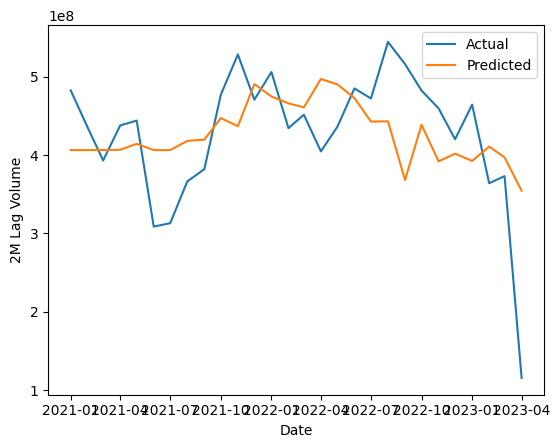

In [1043]:
plt.plot(cdata.index, cdata['2M Lag Volume'], label='Actual')
plt.plot(cdata.index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('2M Lag Volume')
plt.legend()
plt.show()

### Seasonal decompoisition of volume lags

#### 1 Month Lag

In [1044]:
# Perform Holt-Winters decomposition
result = seasonal_decompose(cdata['1M Lag Volume'], model='additive', extrapolate_trend='freq')

In [1045]:
# Extract trend, seasonal, and residual components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

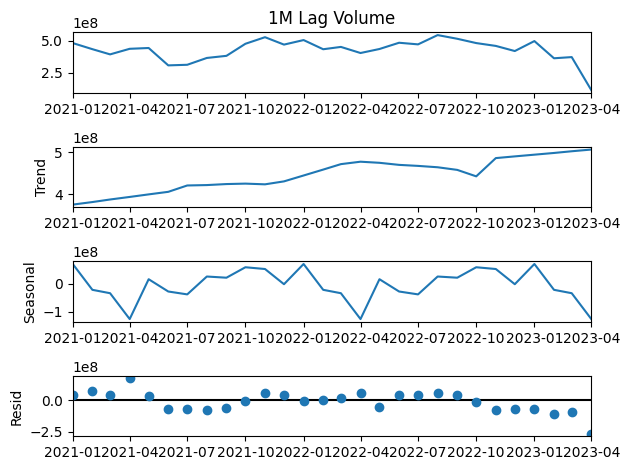

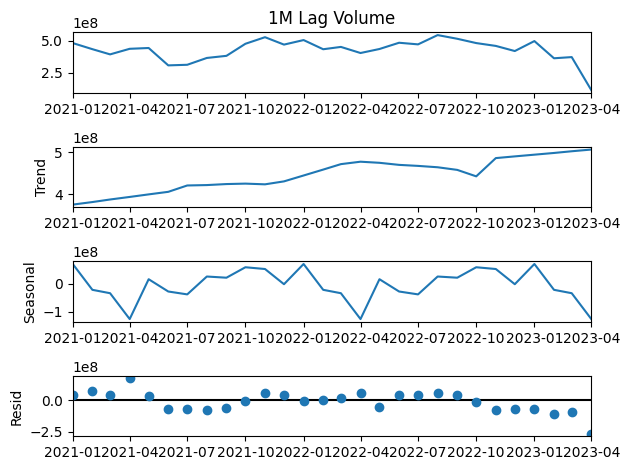

In [1046]:
result.plot()

In [1047]:
residualdf = pd.merge(residual.dropna(), cdata['US_Prime_Rate'], left_index=True, right_index=True, how='inner')
residualdf

,resid,US_Prime_Rate
2021-01-01,3.594808e+07,0.0325
2021-02-01,7.479192e+07,0.0325
2021-03-01,4.021106e+07,0.0325
2021-04-01,1.701375e+08,0.0325
2021-05-01,2.774197e+07,0.0325
2021-06-01,-6.983624e+07,0.0325
2021-07-01,-6.994172e+07,0.0325
2021-08-01,-8.161397e+07,0.0325
2021-09-01,-6.335715e+07,0.0325
2021-10-01,-7.778467e+06,0.0325


In [1048]:
trenddf = pd.merge(trend.dropna(), cdata['Account Management'], left_index=True, right_index=True, how='inner')
trenddf

,trend,Account Management
2021-01-01,3.756404e+08,28330.0
2021-02-01,3.817177e+08,28330.0
2021-03-01,3.877950e+08,28330.0
2021-04-01,3.938724e+08,28710.0
2021-05-01,3.999497e+08,36250.0
2021-06-01,4.060271e+08,28330.0
2021-07-01,4.211319e+08,28330.0
2021-08-01,4.220838e+08,40000.0
2021-09-01,4.244831e+08,41600.0
2021-10-01,4.255410e+08,68900.0


##### Correlation of US Prime Rate on residual component of 1 Month Lagged Volume and Account Managment Spend on trend component of 1 Month Lagged Volume

In [1049]:
# Calculate correlation between residual component and Fed Funds Target Rate
correlation, p_value = pearsonr(residualdf['resid'], residualdf['US_Prime_Rate'])
print(f"Correlation between residual component and the US prime rate: {correlation:.6f}")
print(f"P-value: {p_value:.6f}")

Correlation between residual component and the US prime rate: -0.555590
P-value: 0.002145


In [1050]:
# Calculate correlation between residual component and Fed Funds Target Rate
correlation, p_value = pearsonr(trenddf['trend'], trenddf['Account Management'])
print(f"Correlation between trend component and account management spend: {correlation:.6f}")
print(f"P-value: {p_value:.6f}")

Correlation between trend component and account management spend: 0.897952
P-value: 0.000000


##### Linear regression of trends and residual on account management and US Prime Rate

In [1051]:
X = residualdf['US_Prime_Rate']
y = residualdf['resid']
X = sm.add_constant(X)
model=sm.OLS(y,X)
results = model.fit()
predictions = results.predict(X)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     11.61
Date:                Tue, 30 May 2023   Prob (F-statistic):            0.00215
Time:                        22:37:51   Log-Likelihood:                -544.13
No. Observations:                  28   AIC:                             1092.
Df Residuals:                      26   BIC:                             1095.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.014e+08   3.62e+07      2.800

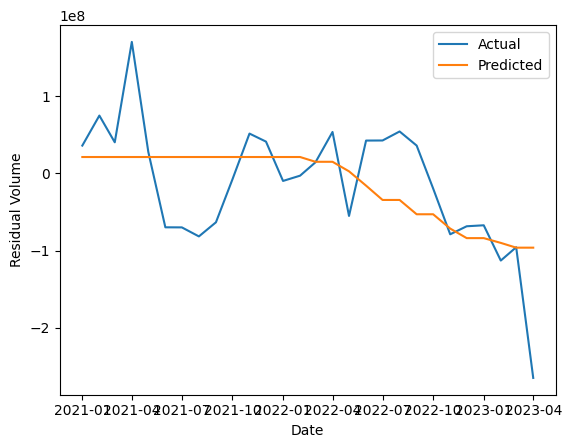

In [1052]:
plt.plot(residualdf.index, residualdf['resid'], label='Actual')
plt.plot(residualdf.index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Residual Volume')
plt.legend()
plt.show()

In [1053]:
X = trenddf['Account Management']
y = trenddf['trend']
X = sm.add_constant(X)
model=sm.OLS(y,X)
results = model.fit()
predictions = results.predict(X)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  trend   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     108.2
Date:                Tue, 30 May 2023   Prob (F-statistic):           9.24e-11
Time:                        22:37:51   Log-Likelihood:                -505.78
No. Observations:                  28   AIC:                             1016.
Df Residuals:                      26   BIC:                             1018.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3.844e+08   6.84

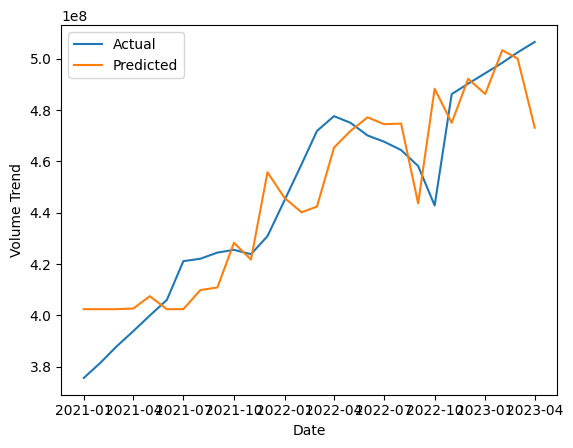

In [1054]:
plt.plot(trenddf.index, trenddf['trend'], label='Actual')
plt.plot(trenddf.index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Volume Trend')
plt.legend()
plt.show()

#### 2 Month Lag

In [1055]:
# Perform Holt-Winters decomposition
result = seasonal_decompose(cdata['2M Lag Volume'], model='additive', extrapolate_trend='freq')

In [1056]:
# Extract trend, seasonal, and residual components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

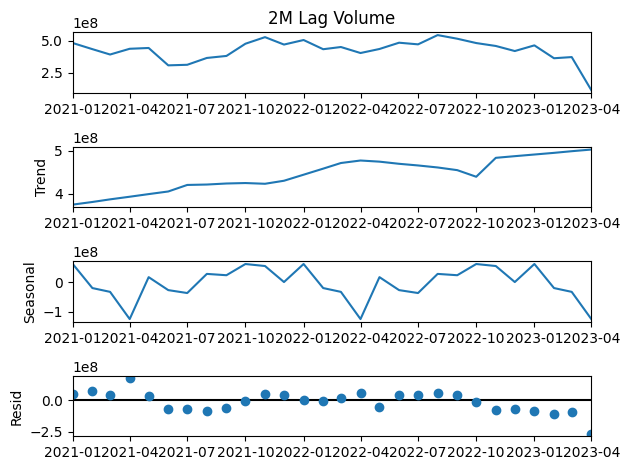

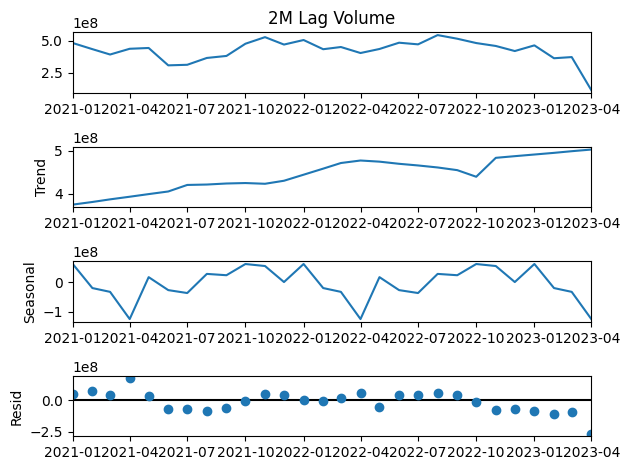

In [1057]:
result.plot()

In [1058]:
residualdf = pd.merge(residual.dropna(), cdata['US_Prime_Rate'], left_index=True, right_index=True, how='inner')
residualdf

,resid,US_Prime_Rate
2021-01-01,4.635003e+07,0.0325
2021-02-01,7.379402e+07,0.0325
2021-03-01,3.873210e+07,0.0325
2021-04-01,1.690915e+08,0.0325
2021-05-01,2.783312e+07,0.0325
2021-06-01,-6.978878e+07,0.0325
2021-07-01,-7.064262e+07,0.0325
2021-08-01,-8.290568e+07,0.0325
2021-09-01,-6.524885e+07,0.0325
2021-10-01,-9.024976e+06,0.0325


In [1059]:
trenddf = pd.merge(trend.dropna(), cdata['Account Management'], left_index=True, right_index=True, how='inner')
trenddf

,trend,Account Management
2021-01-01,3.753272e+08,28330.0
2021-02-01,3.814066e+08,28330.0
2021-03-01,3.874859e+08,28330.0
2021-04-01,3.935653e+08,28710.0
2021-05-01,3.996447e+08,36250.0
2021-06-01,4.057241e+08,28330.0
2021-07-01,4.208342e+08,28330.0
2021-08-01,4.217850e+08,40000.0
2021-09-01,4.241935e+08,41600.0
2021-10-01,4.252510e+08,68900.0


##### Correlation of US Prime Rate on residual component of 2 Month Lagged Volume and Account Managment Spend on trend component of 2 Month Lagged Volume

In [1060]:
# Calculate correlation between residual component and Fed Funds Target Rate
correlation, p_value = pearsonr(residualdf['resid'], residualdf['US_Prime_Rate'])
print(f"Correlation between residual component and the US prime rate: {correlation:.6f}")
print(f"P-value: {p_value:.6f}")

Correlation between residual component and the US prime rate: -0.561420
P-value: 0.001881


In [1061]:
# Calculate correlation between residual component and Fed Funds Target Rate
correlation, p_value = pearsonr(trenddf['trend'], trenddf['Account Management'])
print(f"Correlation between trend component and account management spend: {correlation:.6f}")
print(f"P-value: {p_value:.6f}")

Correlation between trend component and account management spend: 0.893173
P-value: 0.000000


##### Linear regression of trends and residual on account management and US Prime Rate

In [1062]:
X = residualdf['US_Prime_Rate']
y = residualdf['resid']
X = sm.add_constant(X)
model=sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     11.97
Date:                Tue, 30 May 2023   Prob (F-statistic):            0.00188
Time:                        22:37:52   Log-Likelihood:                -544.10
No. Observations:                  28   AIC:                             1092.
Df Residuals:                      26   BIC:                             1095.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.031e+08   3.62e+07      2.849

In [1063]:
X = trenddf['Account Management']
y = trenddf['trend']
X = sm.add_constant(X)
model=sm.OLS(y,X)
results = model.fit()
results_df = results_df.append({'Variable': 'Trend Volume', 'R-squared': results.rsquared, 'Account Management': results.pvalues[1]}, ignore_index=True)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  trend   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     102.6
Date:                Tue, 30 May 2023   Prob (F-statistic):           1.63e-10
Time:                        22:37:52   Log-Likelihood:                -505.73
No. Observations:                  28   AIC:                             1015.
Df Residuals:                      26   BIC:                             1018.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3.849e+08   6.82

C:\Users\cmasterson\AppData\Local\Temp\ipykernel_8972\1310647278.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Variable': 'Trend Volume', 'R-squared': results.rsquared, 'Account Management': results.pvalues[1]}, ignore_index=True)


#### 6 Month Lag

In [1064]:
# Perform Holt-Winters decomposition
result = seasonal_decompose(cdata['6M Lag Volume'], model='additive', extrapolate_trend='freq')

In [1065]:
# Extract trend, seasonal, and residual components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

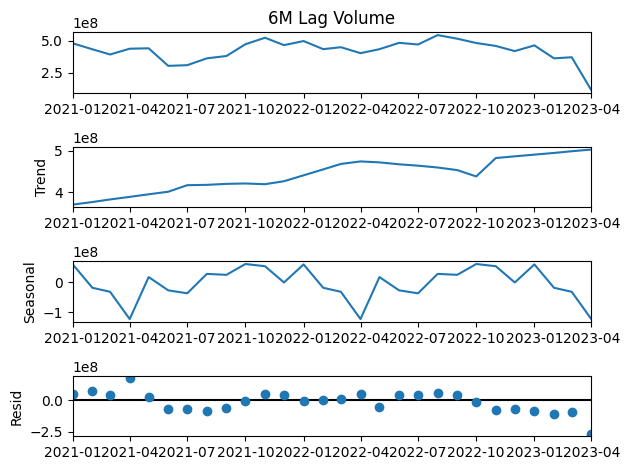

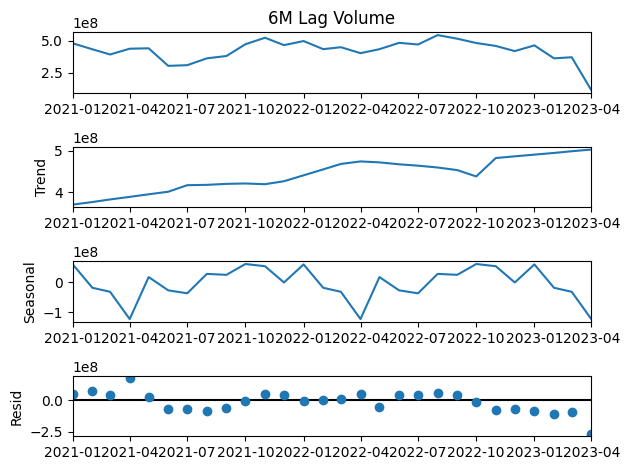

In [1066]:
result.plot()

In [1067]:
residualdf = pd.merge(residual.dropna(), cdata['US_Prime_Rate'], left_index=True, right_index=True, how='inner')
residualdf

,resid,US_Prime_Rate
2021-01-01,4.928198e+07,0.0325
2021-02-01,7.512397e+07,0.0325
2021-03-01,4.190880e+07,0.0325
2021-04-01,1.717868e+08,0.0325
2021-05-01,2.816788e+07,0.0325
2021-06-01,-7.002958e+07,0.0325
2021-07-01,-7.046289e+07,0.0325
2021-08-01,-8.305695e+07,0.0325
2021-09-01,-6.424587e+07,0.0325
2021-10-01,-9.775703e+06,0.0325


In [1068]:
trenddf = pd.merge(trend.dropna(), cdata['Account Management'], left_index=True, right_index=True, how='inner')
trenddf

,trend,Account Management
2021-01-01,3.706236e+08,28330.0
2021-02-01,3.768184e+08,28330.0
2021-03-01,3.830133e+08,28330.0
2021-04-01,3.892081e+08,28710.0
2021-05-01,3.954029e+08,36250.0
2021-06-01,4.015977e+08,28330.0
2021-07-01,4.172936e+08,28330.0
2021-08-01,4.180851e+08,40000.0
2021-09-01,4.204817e+08,41600.0
2021-10-01,4.213872e+08,68900.0


##### Correlation of US Prime Rate on residual component of 6 Month Lagged Volume and Account Managment Spend on trend component of 6 Month Lagged Volume

In [1069]:
# Calculate correlation between residual component and Fed Funds Target Rate
correlation, p_value = pearsonr(residualdf['resid'], residualdf['US_Prime_Rate'])
print(f"Correlation between residual component and the US prime rate: {correlation:.6f}")
print(f"P-value: {p_value:.6f}")

Correlation between residual component and the US prime rate: -0.562433
P-value: 0.001838


In [1070]:
# Calculate correlation between residual component and Fed Funds Target Rate
correlation, p_value = pearsonr(trenddf['trend'], trenddf['Account Management'])
print(f"Correlation between trend component and account management spend: {correlation:.6f}")
print(f"P-value: {p_value:.6f}")

Correlation between trend component and account management spend: 0.896905
P-value: 0.000000


##### Linear regression of trends and residual on account management and US Prime Rate

In [1071]:
X = residualdf['US_Prime_Rate']
y = residualdf['resid']
X = sm.add_constant(X)
model=sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     12.03
Date:                Tue, 30 May 2023   Prob (F-statistic):            0.00184
Time:                        22:37:53   Log-Likelihood:                -544.32
No. Observations:                  28   AIC:                             1093.
Df Residuals:                      26   BIC:                             1095.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.045e+08   3.65e+07      2.865

In [1072]:
X = trenddf['Account Management']
y = trenddf['trend']
X = sm.add_constant(X)
model=sm.OLS(y,X)
results = model.fit()
results_df = results_df.append({'Variable': 'Trend Volume', 'R-squared': results.rsquared, 'Account Management': results.pvalues[1]}, ignore_index=True)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  trend   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     107.0
Date:                Tue, 30 May 2023   Prob (F-statistic):           1.05e-10
Time:                        22:37:53   Log-Likelihood:                -506.23
No. Observations:                  28   AIC:                             1016.
Df Residuals:                      26   BIC:                             1019.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3.798e+08   6.95

C:\Users\cmasterson\AppData\Local\Temp\ipykernel_8972\1310647278.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Variable': 'Trend Volume', 'R-squared': results.rsquared, 'Account Management': results.pvalues[1]}, ignore_index=True)
